# Analyze the relationship between heat vulnerability and tree canopy change

This notebook implements exporatory spatial data analysis and geographically-weighted regression to test the relationship between heat vulnerability and change in tree canopy cover.

reusable components:
- GWR

ToC:
1. read in and join data sources 
2. expoloratory analysis
check for autocorrelation
3. implement spatially-adjusted regression
4. implement geographically-weighted regression


## ready data

### load packages

In [ ]:
# Install gdal
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,262 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 155332 files and directories currently installed.)
Preparing to unpack .../python3-numpy_

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
plt.rcParams['figure.figsize'] = (12,10)

In [ ]:
dir = '/content/drive/MyDrive/Advanced Spatial/project 1/'

### read in heat index

In [ ]:
# heat vulnerability index 
# from:
# https://a816-dohbesp.nyc.gov/IndicatorPublic/VisualizationData.aspx?id=2411,719b87,107,Summarize

In [ ]:
hvi = pd.read_csv(f'{dir} + Heat Vulnerability Index by NTA.csv', header=6)

In [ ]:
hvi.sort_values('Geography ID').head()

,Year,GeoTypeName,Borough,Geography,Geography ID,Indicator Name,Score (Lowest 1 - Highest 5),Notes Score,Unnamed: 8
32,2018,Neighborhood (NTA),Bronx,Claremont-Bathgate,501.0,Heat Vulnerability Index by NTA,5.0,NaN,NaN
56,2018,Neighborhood (NTA),Bronx,Eastchester-Edenwald-Baychester,503.0,Heat Vulnerability Index by NTA,5.0,NaN,NaN
11,2018,Neighborhood (NTA),Bronx,Bedford Park-Fordham North,505.0,Heat Vulnerability Index by NTA,4.0,NaN,NaN
13,2018,Neighborhood (NTA),Bronx,Belmont,506.0,Heat Vulnerability Index by NTA,5.0,NaN,NaN
20,2018,Neighborhood (NTA),Bronx,Bronxdale,507.0,Heat Vulnerability Index by NTA,4.0,NaN,NaN


In [ ]:
# drop text from bottom

hvi = hvi.iloc[:188]

In [ ]:
boro_codes = {
    'Bronx':'BX',
    'Brooklyn':'BK',
    'Manhattan':'MN',
    'Queens':'QN',
    'Staten Island':'SI'

}

In [ ]:
hvi['NTACode'] = hvi['Borough'].map(boro_codes) + hvi['Geography ID'].astype(str).str.slice(start=-4, stop=-2)

In [ ]:
hvi = hvi.drop('Unnamed: 8',axis=1)

### read in NTAs with canopy sums

In [ ]:
# NTAs joined with canopy sums (computed previously)

nta = gpd.read_file(f'{dir} +nta_2010_with_canopy_sums.geojson')

In [ ]:
nta.head()

,NTACode,BoroCode,BoroName,CountyFIPS,NTAName,Shape_Leng,Shape_Area,no_change,gain,loss,total_2010,total_2017,percent_gain,percent_loss,geometry
0,BK09,3,Brooklyn,047,Brooklyn Heights-Cobble Hill,14264.578478,9.985088e+06,1.803272e+06,6.374755e+05,2.832982e+05,2.086570e+06,2.440748e+06,0.305514,0.135772,"POLYGON ((986367.735 190549.239, 985813.835 19..."
1,BK17,3,Brooklyn,047,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91050.717103,6.334575e+07,8.660154e+06,2.586507e+06,3.507120e+06,1.216727e+07,1.124666e+07,0.212579,0.288242,"POLYGON ((1006999.999 152990.449, 1006990.919 ..."
2,BK19,3,Brooklyn,047,Brighton Beach,21058.063993,1.718055e+07,1.471984e+06,6.126246e+05,9.613306e+05,2.433314e+06,2.084609e+06,0.251765,0.395070,"POLYGON ((995262.898 153250.430, 995272.032 15..."
3,BK21,3,Brooklyn,047,Seagate-Coney Island,51876.664709,3.876920e+07,2.007176e+06,1.135529e+06,1.797455e+06,3.804631e+06,3.142705e+06,0.298460,0.472439,"POLYGON ((991308.054 151730.650, 991307.530 15..."
4,BK23,3,Brooklyn,047,West Brighton,14113.581565,8.738769e+06,1.231623e+06,2.806869e+05,6.838629e+05,1.915486e+06,1.512309e+06,0.146536,0.357018,"POLYGON ((992892.358 148861.161, 992876.817 14..."


### join data

In [ ]:
nta = nta.merge(hvi, on='NTACode')

In [ ]:
nta = nta.rename(columns={'Score (Lowest 1  -  Highest 5)':'HVI_score'})

## check for relationships (exploratory analysis)

In [ ]:
nta.columns

Index(['NTACode', 'BoroCode', 'BoroName', 'CountyFIPS', 'NTAName',
       'Shape_Leng', 'Shape_Area', 'no_change', 'gain', 'loss', 'total_2010',
       'total_2017', 'percent_gain', 'percent_loss', 'geometry', 'Year',
       'GeoTypeName', 'Borough', 'Geography', 'Geography ID', 'Indicator Name',
       'HVI_score', 'Notes Score'],
      dtype='object')

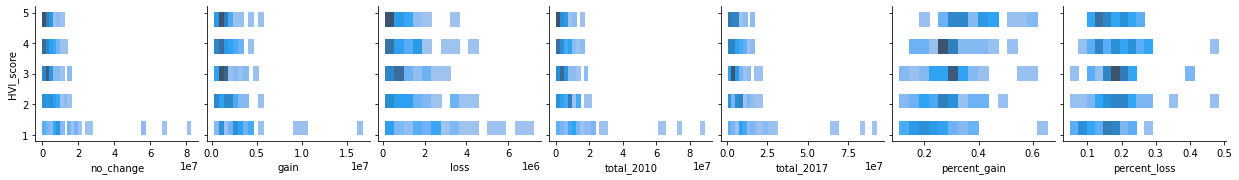

In [ ]:
sns.pairplot(
    nta,
    x_vars=['no_change', 'gain', 'loss', 'total_2010','total_2017', 'percent_gain', 'percent_loss'],
    y_vars=['HVI_score'],
    kind='hist'
)

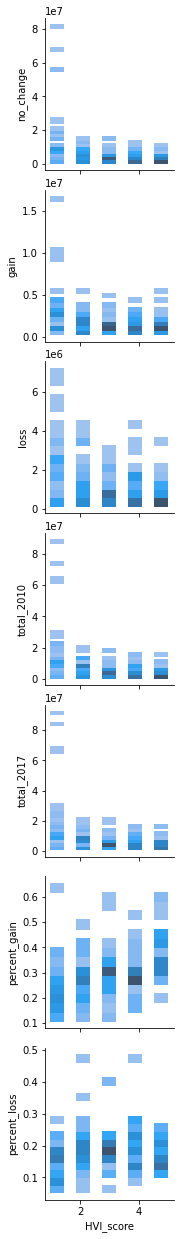

In [ ]:
sns.pairplot(
    nta,
    y_vars=['no_change', 'gain', 'loss', 'total_2010','total_2017', 'percent_gain', 'percent_loss'],
    x_vars=['HVI_score'],
    kind='hist'
)

In [ ]:
smf.ols('HVI_score ~ percent_gain', data = nta).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              HVI_score   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     39.17
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           2.62e-09
Time:                        15:55:26   Log-Likelihood:                -312.95
No. Observations:                 188   AIC:                             629.9
Df Residuals:                     186   BIC:                             636.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.2181      0.300      4.064      0.000       0.627       1.809
percent_gain     5.9279      0.947      6.258      0.000       4.059       7.797
==============================================================================
Omnibus:                        9.526   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                4.984
Skew:                          -0.182   Prob(JB):                       0.0827
Kurtosis:                       2.290   Cond. No.                         11.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


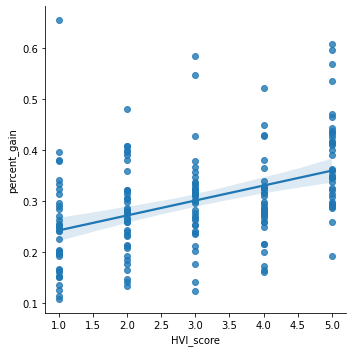

In [ ]:
sns.lmplot('HVI_score','percent_gain', data=nta)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


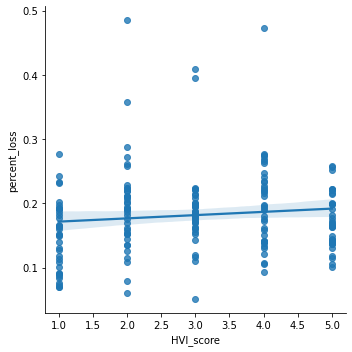

In [ ]:
sns.lmplot('HVI_score','percent_loss', data=nta)

## check autocorrelation

In [ ]:
pip install -U esda

     |████████████████████████████████| 95 kB 1.7 MB/s 
  Created wheel for esda: filename=esda-2.4.1-py3-none-any.whl size=117429 sha256=b6a2215190c9c4112e458de2353d5769ce24bf60a791e6acb314ce05ad764801
  Stored in directory: /root/.cache/pip/wheels/ed/67/c5/4558a178be4c410f341c31f71b5aba9c761a40c9d17dbdfddd
Successfully built esda


In [ ]:
import esda

In [ ]:
from libpysal.weights.contiguity import Queen

In [ ]:
# compute contiguity matrix

w = Queen.from_dataframe(nta)


/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


(<Figure size 864x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2678b85210>)

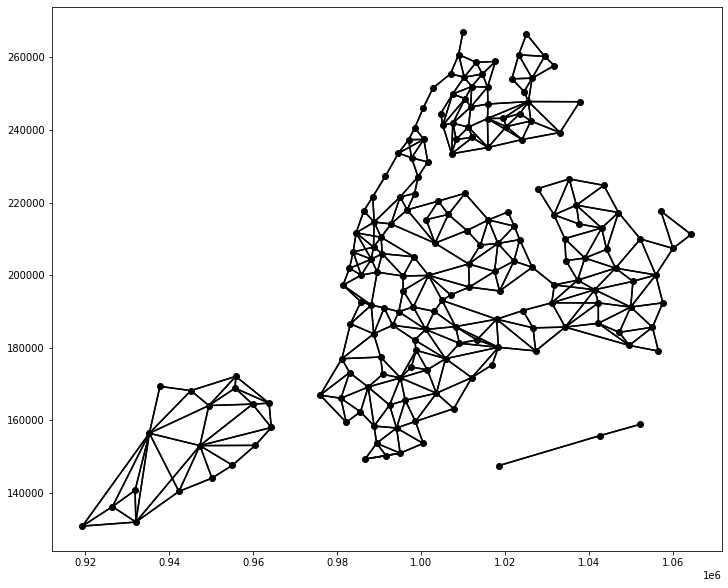

In [ ]:
# find those dosconnected areas : it's the rockaways

w.plot(nta)

In [ ]:
# check for missing data : yay none!

nta.isna().any()

NTACode           False
BoroCode          False
BoroName          False
CountyFIPS        False
NTAName           False
Shape_Leng        False
Shape_Area        False
no_change         False
gain              False
loss              False
total_2010        False
total_2017        False
percent_gain      False
percent_loss      False
geometry          False
Year              False
GeoTypeName       False
Borough           False
Geography         False
Geography ID      False
Indicator Name    False
HVI_score         False
Notes Score        True
dtype: bool

In [ ]:
from esda.moran import Moran
from esda.geary import Geary

In [ ]:
# check autocorrelation on these variables

vars = ['no_change', 'gain', 'loss', 'total_2010', 'total_2017', 'percent_gain', 'percent_loss','HVI_score']

In [ ]:
Is = []
Cs = []

for var in vars:

  moran = Moran(nta[var], w)
  Is.append(moran.I)

  geary = Geary(nta[var], w)
  Cs.append(geary.C)


autocorrelation = pd.DataFrame(index=vars, data={'Morans I':Is, 'Gearys c':Cs})
autocorrelation

,Morans I,Gearys c
no_change,0.590194,0.697558
gain,0.600949,0.668741
loss,0.587792,0.481096
total_2010,0.601444,0.667741
total_2017,0.606259,0.680883
percent_gain,0.415003,0.565526
percent_loss,0.561631,0.436160
HVI_score,0.620281,0.371714


(0.0, 1.0)

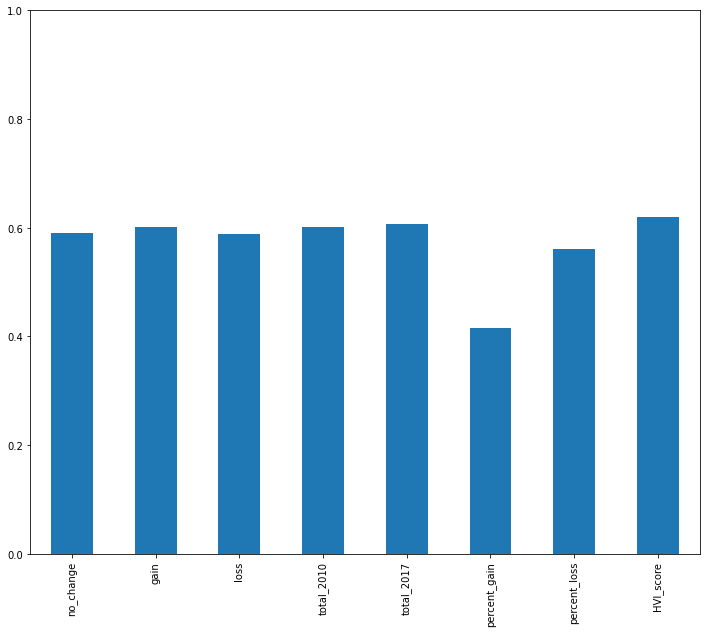

In [ ]:
autocorrelation['Morans I'].plot.bar()
plt.ylim(0,1)

(0.0, 2.0)

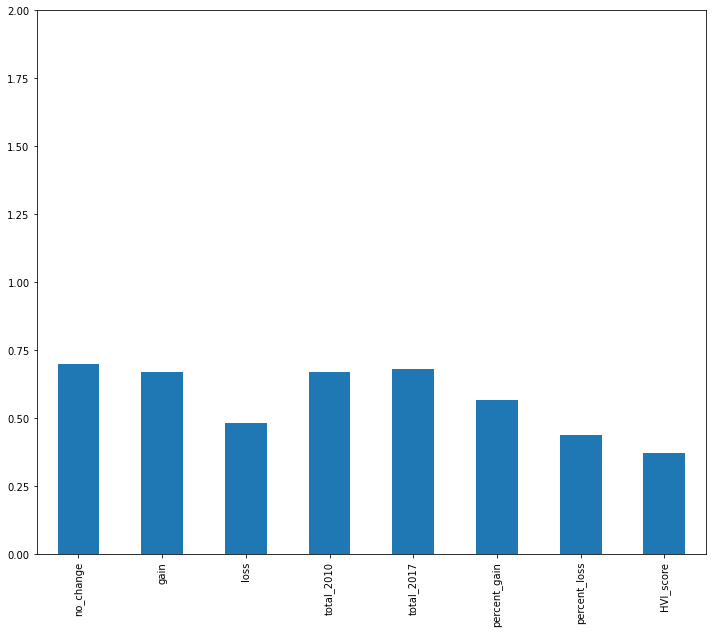

In [ ]:
autocorrelation['Gearys c'].plot.bar()
plt.ylim(0,2)

In [ ]:
# there is _some_ spatial autocorrelation across all the variables (but maybe not a ton?)

## implement a spatially-adjusted regression

In [ ]:
pip install spreg

In [ ]:
import spreg

In [ ]:
# create numpy vertical arrays for spreg spatial regression

y = nta['percent_gain'].to_numpy()
x = nta['HVI_score'].to_numpy()

In [ ]:
y.shape = (len(y), 1)

In [ ]:
x.shape = (len(x), 1)

In [ ]:
# spatial lag regression

lag = spreg.ML_Lag(
    y=y, 
    x=x, 
    w=w,
    name_y='percent canopy gain',
    name_x=['HVI score']
    )

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
print(lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :percent canopy gain                Number of Observations:         188
Mean dependent var  :      0.3006                Number of Variables   :           3
S.D. dependent var  :      0.0992                Degrees of Freedom    :         185
Pseudo R-squared    :      0.3858
Spatial Pseudo R-squared:  0.1700
Sigma-square ML     :       0.006                Log likelihood        :     205.237
S.E of regression   :       0.078                Akaike info criterion :    -404.474
                                                 Schwarz criterion     :    -394.765

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------

## geographically weighted regression

In [ ]:
pip install mgwr

In [ ]:
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler

In [ ]:
# select exog and endog variables - as numpy arrays to feed into mgwr

y = nta['percent_gain'].to_numpy()
x = nta['HVI_score'].to_numpy()

In [ ]:
# standard scale variables

y = StandardScaler().fit(y).transform(y)
x = StandardScaler().fit(x).transform(x)

In [ ]:
# get centroids of nta areas and store as list of coordinates

nta_points = []
for points in nta.centroid:
    nta_points.append([points.x, points.y])

print(nta_points)

[[985672.5897497226, 192654.35838652655], [1000495.0690458816, 153615.09000830844], [995023.3650504996, 150924.59386935542], [986685.1529580099, 149304.38310798942], [991641.5229069459, 150255.1767124874], [994154.4649486608, 157857.7851951648], [989407.506983896, 153648.03094896767], [982172.3142932933, 159424.72047355864], [985565.9799442089, 162325.1261206409], [988819.4459455619, 158392.16858804986], [980892.1577699251, 166047.7082998989], [975953.5842524726, 166928.7259183289], [981131.6934065969, 176956.10076731563], [983168.2414192064, 186571.1227844047], [982960.4441563241, 173133.882713599], [1003139.5818833091, 190001.98716485838], [988715.1477131079, 183823.29336670425], [988136.0901286314, 191728.58680483577], [990359.2944071039, 177405.53480907035], [990855.5006980749, 172661.48597827856], [995082.324189726, 171682.88353142777], [996235.9750795998, 165498.62550071906], [998651.5086971355, 159666.94559932104], [1007780.7430798465, 163195.91211239804], [992488.3345135595, 16

In [ ]:
# search for best bandwidth

gwr_selector = Sel_BW(nta_points, y, x)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)

/usr/local/lib/python3.7/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.41144e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.7/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=5.43711e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)


19.0


In [ ]:
# fit gwr

gwr_results = GWR(nta_points, y, x, gwr_bw).fit()

In [ ]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 188
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            155.297
Log-likelihood:                                                    -248.797
AIC:                                                                501.594
AICc:                                                               503.724
BIC:                                                               -818.681
R2:                                                                   0.174
Adj. R2:                                                              0.170

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
# (quasi-) R2 up to .66

In [ ]:
# put gwr results into geodataframe with original nta areas

result = gpd.GeoDataFrame(gwr_results.params, columns=['c0', 'c1'], geometry=nta['geometry'])
result['local R2'] = gwr_results.localR2

In [ ]:
result

,c0,c1,geometry,local R2
0,0.262044,-0.831908,"POLYGON ((986367.735 190549.239, 985813.835 19...",0.548323
1,-0.140313,0.671521,"POLYGON ((1006999.999 152990.449, 1006990.919 ...",0.370376
2,-0.107844,0.365520,"POLYGON ((995262.898 153250.430, 995272.032 15...",0.417601
3,-0.056140,0.091770,"POLYGON ((991308.054 151730.650, 991307.530 15...",0.418486
4,-0.092493,0.265938,"POLYGON ((992892.358 148861.161, 992876.817 14...",0.413787
...,...,...,...,...
183,-0.659897,-0.074091,"POLYGON ((966187.482 153868.426, 966187.523 15...",0.242590
184,-0.466749,0.045768,"POLYGON ((964105.855 171704.149, 964108.217 17...",0.381316
185,-0.499110,0.148842,"POLYGON ((960721.609 147492.642, 960370.525 14...",0.229757
186,-0.300954,0.525092,"POLYGON ((936499.881 143900.531, 936394.500 14...",0.362112


In [ ]:
from matplotlib.colors import TwoSlopeNorm

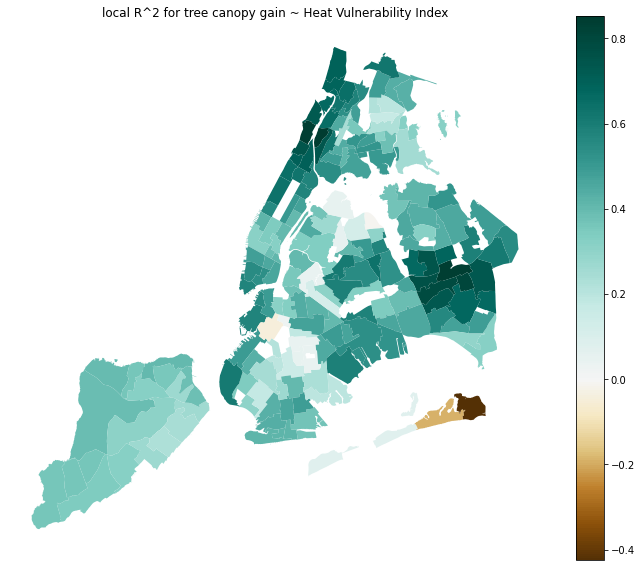

In [ ]:
fig, ax = plt.subplots()

# norm colors
vmin, vmax, vcenter = result['local R2'].min(), result['local R2'].max(), 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'BrBG'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# plot data
result.plot(column='local R2', cmap=cmap, norm=norm, ax=ax)

plt.title('local R^2 for tree canopy gain ~ Heat Vulnerability Index')

# show legend
fig.colorbar(cbar)
plt.axis('off')

plt.show()


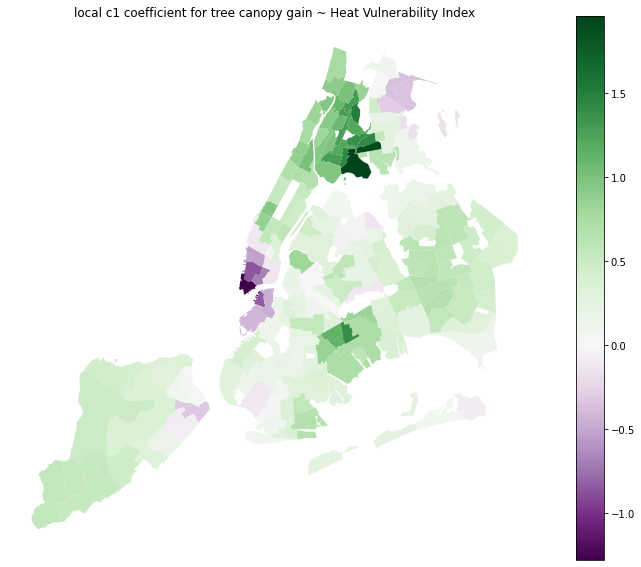

In [ ]:
fig, ax = plt.subplots()

# norm colors
vmin, vmax, vcenter = result['c1'].min(), result['c1'].max(), 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'PRGn'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# plot data
result.plot(column='c1', cmap=cmap, norm=norm, ax=ax)

plt.title('local c1 coefficient for tree canopy gain ~ Heat Vulnerability Index')

# show legend
fig.colorbar(cbar)
plt.axis('off')

plt.show()

In [ ]:
pip install mapclassify

In [ ]:
import mapclassify

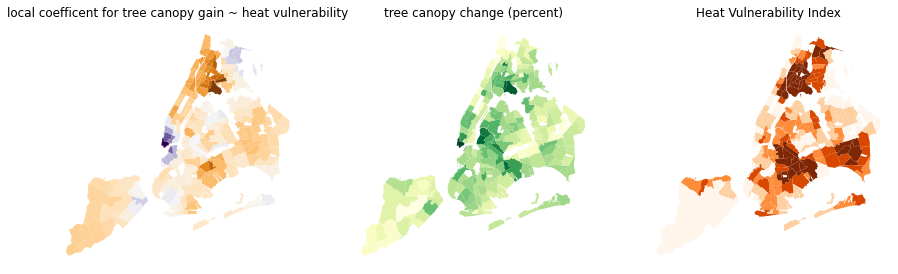

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

## for local coefficient map

# norm colors
vmin, vmax, vcenter = result['c1'].min(), result['c1'].max(), 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'PuOr_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# plot data
result.plot(column='c1', cmap=cmap, norm=norm, ax=ax[0])

ax[0].set_title('local coefficent for tree canopy gain ~ heat vulnerability')
ax[0].axis('off')



## for canopy change map

nta.plot(column='percent_gain', cmap='YlGn', ax=ax[1])
ax[1].set_title('tree canopy change (percent)')
ax[1].axis('off')


## for hvi map

nta.plot(column='HVI_score', cmap='Oranges',ax=ax[2])
ax[2].set_title('Heat Vulnerability Index')
ax[2].axis('off')


plt.show()

In [ ]:
## version with scale bars

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

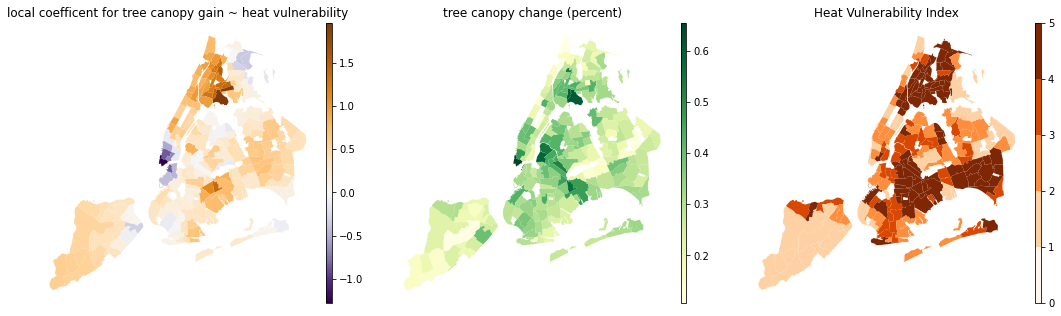

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

## for local coefficient map

# norm colors
vmin, vmax, vcenter = result['c1'].min(), result['c1'].max(), 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'PuOr_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# plot data

# place colorband legend
divider_0 = make_axes_locatable(ax[0])
cax_0 = divider_0.append_axes('right', size='2%', pad=0.1)

result.plot(column='c1', cmap=cmap, norm=norm, ax=ax[0], legend=True, cax=cax_0)

ax[0].set_title('local coefficent for tree canopy gain ~ heat vulnerability')
ax[0].axis('off')



## for canopy change map

divider_1 = make_axes_locatable(ax[1])
cax_1 = divider_1.append_axes('right', size='2%', pad=0.1)

nta.plot(column='percent_gain', cmap='YlGn', ax=ax[1], legend=True, cax=cax_1)
ax[1].set_title('tree canopy change (percent)')
ax[1].axis('off')


## for hvi map

divider_2 = make_axes_locatable(ax[2])
cax_2 = divider_2.append_axes('right', size='2%', pad=0.1)

# make a 5-segment discrete colorramp
cmap = plt.cm.Oranges  # define the colormap
# extract all colors from the Oranges
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new cmap
oranges_c = LinearSegmentedColormap.from_list(
    'oranges_c', cmaplist, cmap.N)
# define the bins and normalize
bounds = [0,1,2,3,4,5]
norm = BoundaryNorm(bounds, cmap.N)



nta.plot(column='HVI_score', cmap=oranges_c, ax=ax[2], legend=True, norm=norm, cax=cax_2)
ax[2].set_title('Heat Vulnerability Index')
ax[2].axis('off')


plt.show()